## Prepare the inputs

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import scipy.misc
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import warnings; warnings.simplefilter('ignore')
import h5py

### Prepare data -- Training
dataset: choose train dataset or test dataset

Based on the paper, using a relatively small training set that consista 91 images. The size of training sub-images is 33, thus the 91-image dataset can be decomposed into 24800 sub-images, which are extracted from original iamges with a stride of 14.

In [13]:
image_size = 33
label_size = 21
scale = 3
stride = 14
c_dim = 1

In [14]:
# Load data path
dataset = 'Train'
data_dir = os.path.join(os.getcwd(), dataset)
data = glob.glob(os.path.join(data_dir, "*.bmp"))

In [15]:
def preprocess(path, scale):
    """
    Preprocess single image file:
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
    
    Args:
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
    """
    image = imread(path, is_grayscale=True)
    label_ = modcrop(image,scale)
    
    #Normalized
    image = image / 255
    label_ = label_ / 255
    
    input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)
    
    return input_, label_

In [16]:
def imread(path, is_grayscale=True):
    if is_grayscale:
        return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
    else:
        return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

In [17]:
def modcrop(image, scale=3):
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
    """
    if len(image.shape) == 3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

### Display Input and Groundtruth

(174, 195)
(174, 195)


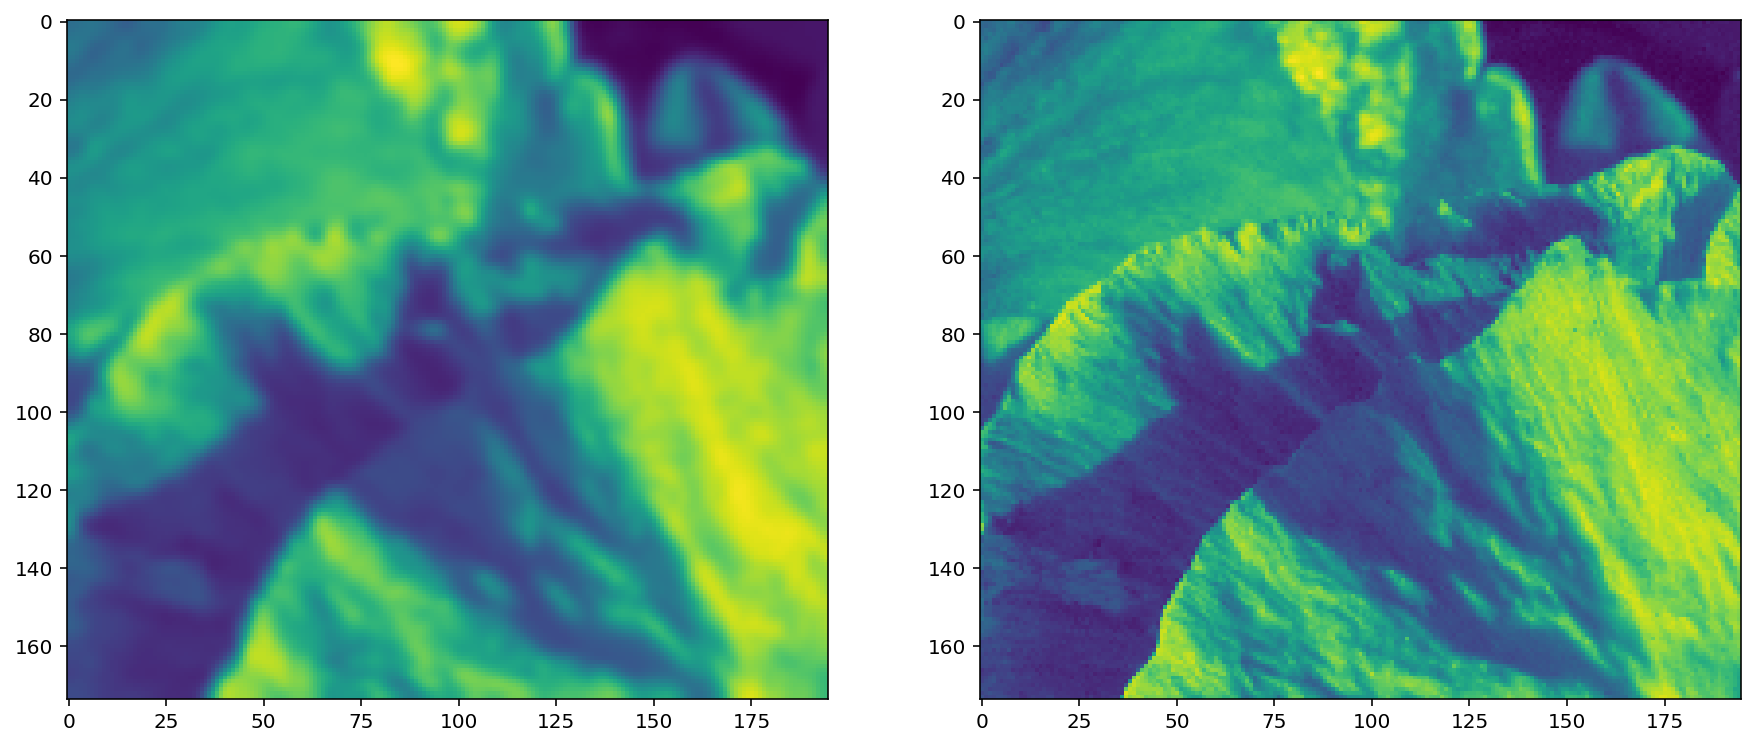

In [18]:
input_, label_ = preprocess(data[0], scale)
plt.figure(figsize=(15,15))
for i, image in enumerate([input_,label_]):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)

### Read image files and make their sub-images and save them as a h5 file format

In [19]:
sub_input_sequence = []
sub_label_sequence = []
padding = int(abs(image_size - label_size)/2)

for i in range(len(data)):
    if i%10 == 0:
        input_, label_ = preprocess(data[i], scale)
        if len(input_.shape)==3:
            h,w,_ = input_.shape
        else:
            h,w = input_.shape
        
        for x in range(0, h-image_size+1, stride):
            for y in range(0, w-image_size+1, stride):
                sub_input=input_[x:x+image_size,y:y+image_size] # 31x31
                sub_label=label_[x+padding:x+padding+label_size, y+padding:y+padding+label_size] # 21x21
        
                # Add Channel Value
                sub_input = sub_input.reshape([image_size, image_size, 1])
                sub_label = sub_label.reshape([label_size, label_size, 1])
                
                sub_input_sequence.append(sub_input)
                sub_label_sequence.append(sub_label)
                

In [20]:
"""
the number of sub_input (33 x 33 x ch) in one image
"""
len(sub_input_sequence)

2699

In [21]:
"""
Make list to numpy array
"""
arrdata = np.asarray(sub_input_sequence)
arrlabel = np.asarray(sub_label_sequence)

In [22]:
arrdata.shape

(2699, 33, 33, 1)

In [23]:
"""
Make input data as h5 file format
"""
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')
savepath = os.path.join(os.getcwd(), 'checkpoint/train.h5')
with h5py.File(savepath, 'w') as hf:
    hf.create_dataset('data', data=arrdata)
    hf.create_dataset('label', data=arrlabel)

### Checkpoint
The preprocessed data has been saved to disk.

In [24]:
data_dir = os.path.join('./{}'.format('checkpoint'), "train.h5")

def read_data(path):
    with h5py.File(path, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        return data, label
train_data, train_label = read_data(data_dir)

## Build the network

In [25]:
import tensorflow as tf

In [26]:
"""
Inputs:
"""
images = tf.placeholder(tf.float32,[None, image_size, image_size, c_dim], name='images')
labels = tf.placeholder(tf.float32,[None, label_size, label_size, c_dim], name='labels')

In [27]:
"""
Weights and Biases:
"""
weights = {
    'w1': tf.Variable(tf.random_normal([9,9,1,64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1,1,64,32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5,5,32,1], stddev=1e-3), name='w3')
}
biases = {
    'b1': tf.Variable(tf.zeros([64]), name='b1'),
    'b2': tf.Variable(tf.zeros([32]), name='b2'),
    'b3': tf.Variable(tf.zeros([1]),name='b3')
}

In [28]:
"""
Model:
"""
conv1 = tf.nn.relu(tf.nn.conv2d(images, 
                                weights['w1'], 
                                strides=[1,1,1,1], 
                                padding='VALID')+biases['b1'])
conv2 = tf.nn.relu(tf.nn.conv2d(conv1, 
                                weights['w2'], 
                                strides=[1,1,1,1], 
                                padding='VALID')+biases['b2'])
conv3 = tf.nn.relu(tf.nn.conv2d(conv2, 
                                weights['w3'], 
                                strides=[1,1,1,1], 
                                padding='VALID')+biases['b3'])
pred = conv3

In [29]:
"""
Loss function (MSE)
"""
loss = tf.reduce_mean(tf.square(labels - pred))

saver = tf.train.Saver()

## Train the network

In [30]:
learning_rate = 1e-4
epoch = 5
batch_size = 64

In [31]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [32]:
import time

In [63]:
print('Checking the Training on a single batch...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    counter = 0
    start_time = time.time()
    
    for ep in range(epoch):
        batch_idxs = len(train_data) // batch_size
        for idx in range(0, batch_idxs):
            batch_images = train_data[idx*batch_size : (idx+1)*batch_size]
            batch_labels = train_label[idx*batch_size : (idx+1)*batch_size]
            
            counter += 1
            _, err = sess.run([train_op, loss], feed_dict={images: batch_images, labels: batch_labels})
            
            
            print("Epoch: [%2d], step: [%2d], time: [%4.4f], loss: [%.8f]"%((ep+1), counter, time.time()-start_time, err))

            if counter % 20 == 0:
                
                model_name = "SRCNN.model"
                model_dir = "%s_%s" % ("srcnn", label_size)
                checkpoint_dir = os.path.join('checkpoint', model_dir)

                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                saver.save(sess, os.path.join(checkpoint_dir, model_name), global_step=counter)

Checking the Training on a single batch...
Epoch: [ 1], step: [ 1], time: [0.1556], loss: [0.28878021]
Epoch: [ 1], step: [ 2], time: [0.2965], loss: [0.34795266]
Epoch: [ 1], step: [ 3], time: [0.4132], loss: [0.33753121]
Epoch: [ 1], step: [ 4], time: [0.5416], loss: [0.31323817]
Epoch: [ 2], step: [ 5], time: [0.6633], loss: [0.28878021]
Epoch: [ 2], step: [ 6], time: [0.7846], loss: [0.34795266]
Epoch: [ 2], step: [ 7], time: [0.9123], loss: [0.33753121]
Epoch: [ 2], step: [ 8], time: [1.0411], loss: [0.31323817]
Epoch: [ 3], step: [ 9], time: [1.1621], loss: [0.28878021]
Epoch: [ 3], step: [10], time: [1.2883], loss: [0.34795266]
Epoch: [ 3], step: [11], time: [1.4099], loss: [0.33753121]
Epoch: [ 3], step: [12], time: [1.5348], loss: [0.31323817]
Epoch: [ 4], step: [13], time: [1.6619], loss: [0.28878021]
Epoch: [ 4], step: [14], time: [1.7939], loss: [0.34795266]
Epoch: [ 4], step: [15], time: [1.9229], loss: [0.33753121]
Epoch: [ 4], step: [16], time: [2.0636], loss: [0.3132381

## Generating HR Image

In [27]:
sample_dir = 'sample'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### Input Setup

In [33]:
data_dir = os.path.join(os.sep, (os.path.join(os.getcwd(), 'Test')), "Set5")
data = glob.glob(os.path.join(data_dir, "*.bmp"))

In [34]:
sub_input_sequence = []
sub_label_sequence = []
padding = int(abs(image_size - label_size)/2)

input_, label_ = preprocess(data[2], scale)

(255, 255)
(255, 255)


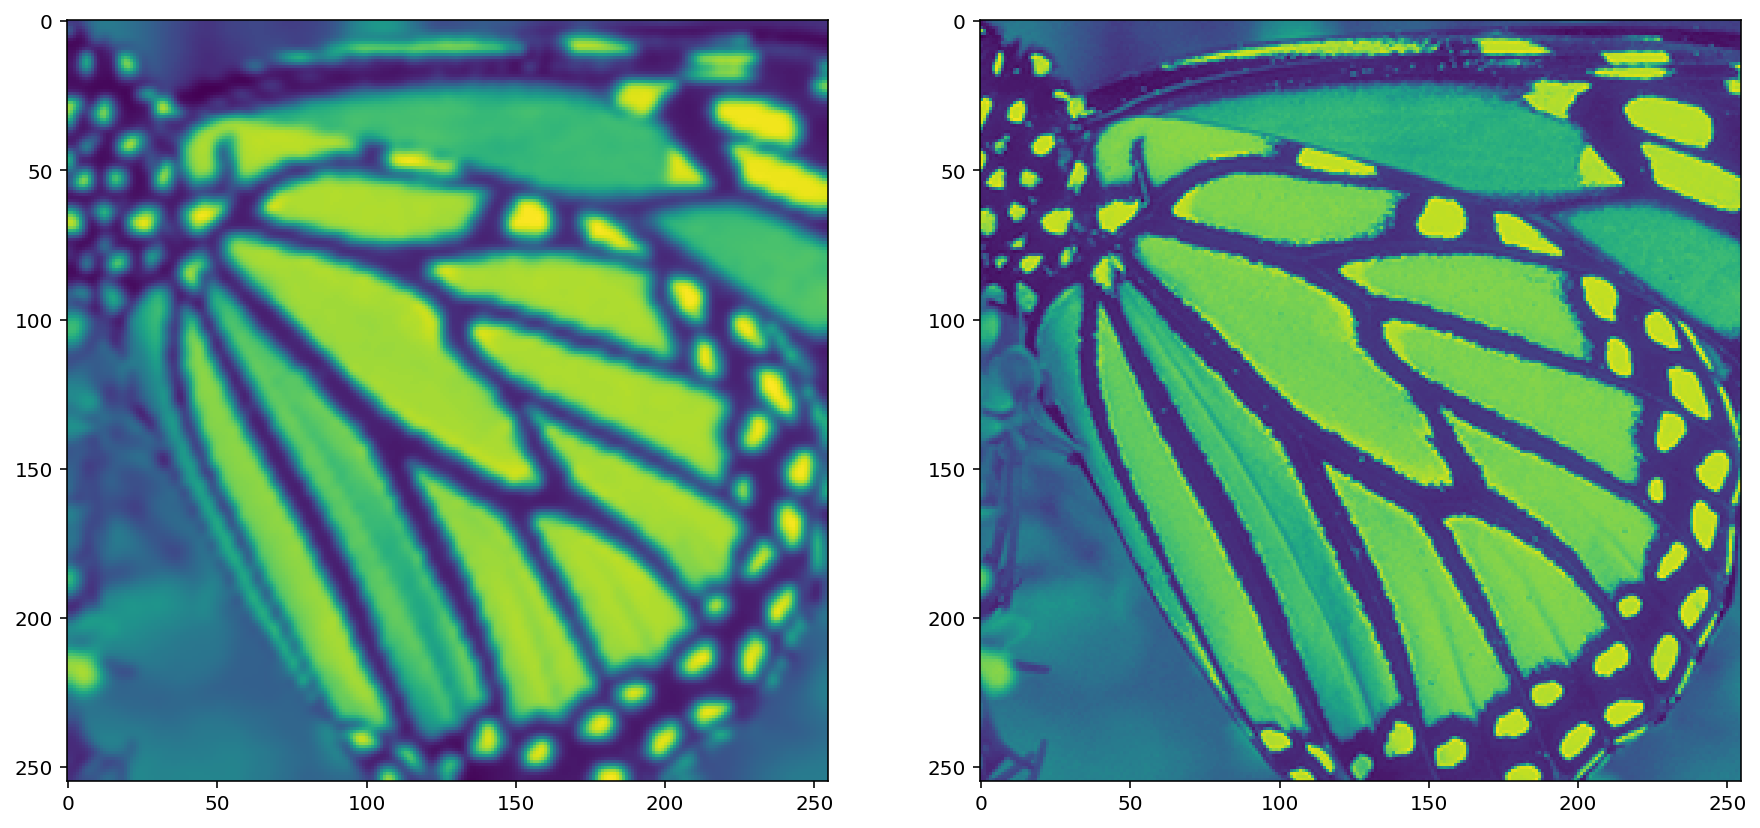

In [37]:
plt.figure(figsize=(15,15))
for i, image in enumerate([input_,label_]):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)